# importieren wichtige Pakete

In [39]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import make_scorer
from numpy.polynomial.polynomial import Polynomial

pd.set_option('display.max_columns', 500)
# für Visualisierung

#plt.rcParams.keys()
plt.rcParams['ytick.labelsize'] = "large"
plt.rcParams['xtick.labelsize'] = "large"
plt.rcParams['axes.labelsize'] = "large"
plt.rcParams['figure.titlesize'] = "x-large"


import warnings
warnings.filterwarnings("ignore")


## Daten lesen und visualisieren

### Load the data and compute RUL

In [40]:
# Laden die Daten FD003 als Beispiel
def read_data(file_name):
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["Operation Setting "+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["Sensor Measure"+str(i) for i in range(1,22)]
    
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names
    
    data = pd.read_csv(file_name, delim_whitespace=True, header=None)
    print("Größe der Daten : Rows {}, Columns {}".format(data.shape[0], data.shape[1]))
    data.columns = input_file_column_names
    return data

In [41]:
def calculate_rul_and_remove_operational (df):
    df['rul'] = df.groupby('UnitNumber')['Cycle'].transform(lambda x: x.max() - x)
    df['rul'] = df['rul'].apply(lambda x: min(x, 130))
    df.drop(['Operation Setting 1','Operation Setting 2','Operation Setting 3', 'Cycle'], axis=1, inplace=True)
    return df

In [42]:
train_data = read_data('./data/train_FD003.txt')
train_data = calculate_rul_and_remove_operational(train_data)
train_data.head()

Größe der Daten : Rows 24720, Columns 26


,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,130
1,1,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,130
2,1,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,130
3,1,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,130
4,1,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,130


## Schritt 1: Daten Normalisierung und Glättung 

### Entferne Spalten mit konstantem Werten

In [43]:
def identify_and_remove_unique_columns(Dataframe):
    unique_counts = Dataframe.nunique()
    # identify columns with only one unique value and drop them (constant values)
    record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 0: 'nunique'})
    to_drop = list(record_single_unique['feature'])
    Dataframe = Dataframe.drop(columns = to_drop)
    return Dataframe

In [44]:
print("Größe vor der Verarbeitung ", train_data.shape)

train_data_relevant = identify_and_remove_unique_columns(train_data)
print("Größe Nach der Verarbeitung", train_data_relevant.shape)

sensor_columns = [col for col in train_data_relevant.columns if 'Sensor Measure' in col]
train_data_relevant.head()

Größe vor der Verarbeitung  (24720, 23)
Größe Nach der Verarbeitung (24720, 18)


,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21,rul
0,1,642.36,1583.23,1396.84,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,391,39.11,23.3537,130
1,1,642.50,1584.69,1396.89,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,392,38.99,23.4491,130
2,1,642.18,1582.35,1405.61,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,391,38.85,23.3669,130
3,1,642.92,1585.61,1392.27,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,392,38.96,23.2951,130
4,1,641.68,1588.63,1397.65,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,392,39.14,23.4583,130


### Daten Normalisieren mit Z-Score

In [45]:
scaler = StandardScaler()

normalized_train_data = train_data_relevant.copy()
# Normalisierung der Sensormessungeen
normalized_train_data = train_data_relevant.copy()
normalized_train_data[sensor_columns] =  scaler.fit_transform(normalized_train_data[sensor_columns])
normalized_train_data.head()

,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21,rul
0,1,-0.187102,-0.712038,-0.780848,0.781589,-0.341494,-0.704785,-0.097138,-0.353479,-0.385602,-0.227593,-0.389857,0.067687,0.469741,-0.889364,0.488019,-0.263512,130
1,1,0.080574,-0.497656,-0.775732,0.781589,-0.172755,-0.452071,-0.116658,-0.353479,-0.618882,-0.193802,-0.263369,0.523946,0.729201,-0.321641,0.005819,0.375767,130
2,1,-0.531256,-0.841254,0.116524,0.781589,-0.207667,-0.262536,0.306267,-0.353479,-0.652208,-0.313608,-0.453101,0.361559,-0.100409,-0.889364,-0.556747,-0.175058,130
3,1,0.883602,-0.362566,-1.248464,0.781589,0.019257,-0.452071,0.022983,-0.353479,-0.585556,-0.172298,0.052852,0.142821,-0.138419,-0.321641,-0.114730,-0.656192,130
4,1,-1.487242,0.080881,-0.697966,0.781589,-0.117479,-0.199357,0.602065,-0.353479,-0.885488,-0.144650,-0.263369,0.217955,-0.153292,-0.321641,0.608569,0.437416,130


### Polynomial fitting

In [46]:
def fit_polynomial(df, degree=3, col_name_unit_number='UnitNumber'):
    def poly_fit(df, degree):
        # This inner function fits a polynomial to each column, returning the fitted values and coefficients.
        fitted_values = {}
        coeffs = {}
        for col in df.columns:
            poly = Polynomial.fit(range(len(df[col])), df[col], degree)
            fitted_values[col] = poly(range(len(df[col])))
            coeffs[col] = poly.coef
        return pd.DataFrame(fitted_values, index=df.index), coeffs
    
    sensor_columns = df.columns.difference([col_name_unit_number])  # Exclude the unit number column
    all_fitted = []
    all_coeffs = {}
    
    for unit in df[col_name_unit_number].unique():
        unit_data = df.loc[df[col_name_unit_number] == unit, sensor_columns]
        fitted_data, coeffs = poly_fit(unit_data, degree)
        all_fitted.append(df.loc[df[col_name_unit_number] == unit].assign(**fitted_data))
        all_coeffs[unit] = coeffs

    return pd.concat(all_fitted, ignore_index=True), all_coeffs


In [47]:
polynomial_train_data = normalized_train_data.copy()
polynomial_train_data[sensor_columns + ['UnitNumber']], polynomials = fit_polynomial(normalized_train_data[sensor_columns + ['UnitNumber']])
polynomial_train_data.head()

,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21,rul
0,1,-0.479029,-0.370564,-0.671737,0.691252,-0.194179,-0.512835,0.251473,-0.353479,-0.574339,-0.221364,-0.434692,0.339823,0.035303,-0.795006,0.087283,0.218689,130
1,1,-0.473452,-0.372604,-0.667666,0.692488,-0.194883,-0.510064,0.251479,-0.353479,-0.573546,-0.221909,-0.433021,0.340223,0.041340,-0.783435,0.085108,0.213921,130
2,1,-0.468021,-0.374598,-0.663665,0.693713,-0.195583,-0.507329,0.251490,-0.353479,-0.572785,-0.222446,-0.431385,0.340619,0.047265,-0.772046,0.082978,0.209225,130
3,1,-0.462735,-0.376545,-0.659731,0.694926,-0.196280,-0.504629,0.251504,-0.353479,-0.572055,-0.222975,-0.429782,0.341009,0.053081,-0.760838,0.080894,0.204599,130
4,1,-0.457590,-0.378445,-0.655864,0.696129,-0.196975,-0.501963,0.251523,-0.353479,-0.571355,-0.223497,-0.428213,0.341394,0.058787,-0.749807,0.078854,0.200043,130


## Schritt 2: Feature-Auswahl mit Lasso-Regression

In [50]:
def lasso_feature_selection(X, y, alpha=2.7):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    return np.array(X.columns)[lasso.coef_ != 0]

In [51]:
selected_features = lasso_feature_selection(polynomial_train_data[sensor_columns], polynomial_train_data['rul'])
selected_features

array(['Sensor Measure6', 'Sensor Measure9', 'Sensor Measure11'],
      dtype=object)

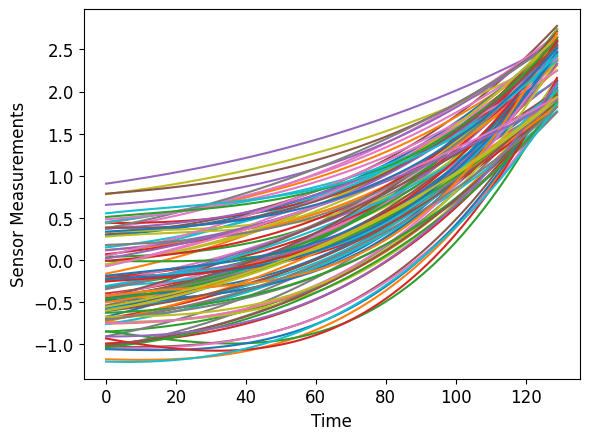

In [52]:
# visualize the smoothed data for unit 1 for each sensor separately
for i in range(101):
    poldata = polynomial_train_data[polynomial_train_data['rul']<130]   
    poly = poldata[poldata['UnitNumber'] == i]['Sensor Measure4']
    plt.plot(range(len(poly)), poly, label='Sensor Measure2_smoothed')
        
plt.xlabel('Time')
plt.ylabel('Sensor Measurements')

plt.show()

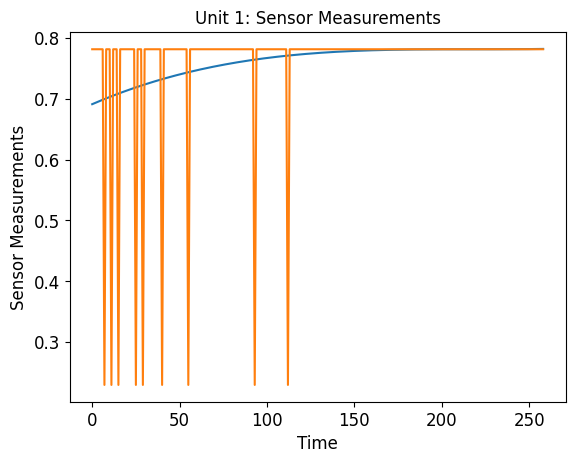

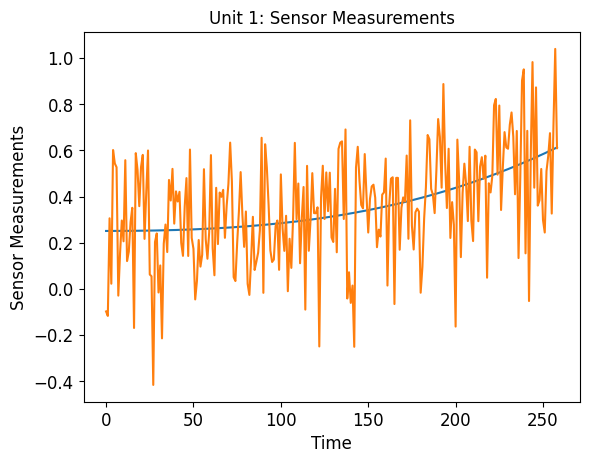

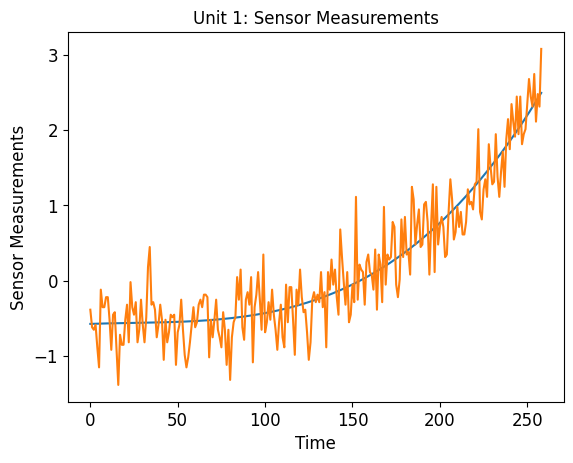

In [53]:
# visualize the unsmoothed and smmothed data for unit 1 for each sensor separately
for col in selected_features:
    plt.plot(polynomial_train_data[polynomial_train_data['UnitNumber'] == 1][col], label=col)
    plt.plot(normalized_train_data[normalized_train_data['UnitNumber'] == 1][col], label=col+'_original')
        
    plt.title('Unit 1: Sensor Measurements')
    plt.xlabel('Time')
    plt.ylabel('Sensor Measurements')
    plt.show()

### Schritt 3: Feature-Extraktion 

In [54]:
selected_polynomial_train_data = polynomial_train_data[[ 'UnitNumber', 'rul']+list(selected_features)]

In [55]:
selected_polynomial_train_data[selected_polynomial_train_data['UnitNumber'] == 1]

,UnitNumber,rul,Sensor Measure6,Sensor Measure9,Sensor Measure11
0,1,130,0.691252,0.251473,-0.574339
1,1,130,0.692488,0.251479,-0.573546
2,1,130,0.693713,0.251490,-0.572785
3,1,130,0.694926,0.251504,-0.572055
4,1,130,0.696129,0.251523,-0.571355
...,...,...,...,...,...
254,1,4,0.781984,0.598663,2.344544
255,1,3,0.782018,0.602262,2.381870
256,1,2,0.782054,0.605885,2.419518
257,1,1,0.782092,0.609532,2.457489


In [56]:
def extract_features(df, window_length=20, stride=20):
    features = []
    targets = []
    unit_numbers = []
    column_names = [col for col in df.columns if 'Sensor Measure' in col]
    for unit in df['UnitNumber'].unique():
        unit_df = df[df['UnitNumber'] == unit]
        for start in range(len(unit_df) - window_length,0, -stride):
            end = start + window_length 
            window = unit_df.iloc[start:end]

            feature_vector = []
            
            for sensor in column_names:
                mean_val = window[sensor].mean()
                trend = np.polyfit(range(window_length), window[sensor], 1)[0]
                feature_vector.extend([mean_val, trend])
                
                #plt.plot(window[sensor])
                #plt.scatter(start+10, mean_val, color='red', label='Mean Value')
               
            features.append(feature_vector)
            unit_numbers.extend([unit])
            targets.append(unit_df.iloc[end-1]['rul'])
            
    cols = []
    for sensor in column_names:
        cols.extend([sensor + '_mean', sensor + '_trend'])
    return_df = pd.DataFrame(data=np.array(features), columns=cols)
    return_df['UnitNumber'] = unit_numbers
    return return_df, pd.DataFrame(targets, columns=['rul'])

In [57]:
x_train , y_train = extract_features(selected_polynomial_train_data[selected_polynomial_train_data['UnitNumber'] == 1])
x_train.head()

,Sensor Measure6_mean,Sensor Measure6_trend,Sensor Measure9_mean,Sensor Measure9_trend,Sensor Measure11_mean,Sensor Measure11_trend,UnitNumber
0,0.781855,0.000024,0.579696,0.003455,2.150132,0.035440,1
1,0.781610,0.000003,0.515230,0.002996,1.501801,0.029468,1
2,0.781577,0.000003,0.459641,0.002568,0.967332,0.024053,1
3,0.781340,0.000024,0.412292,0.002172,0.535572,0.019197,1
4,0.780481,0.000065,0.372545,0.001807,0.195365,0.014898,1


In [58]:
x_train , y_train = extract_features(selected_polynomial_train_data)
pd.concat([x_train, y_train], axis=1).head()

,Sensor Measure6_mean,Sensor Measure6_trend,Sensor Measure9_mean,Sensor Measure9_trend,Sensor Measure11_mean,Sensor Measure11_trend,UnitNumber,rul
0,0.781855,0.000024,0.579696,0.003455,2.150132,0.035440,1,0.0
1,0.781610,0.000003,0.515230,0.002996,1.501801,0.029468,1,20.0
2,0.781577,0.000003,0.459641,0.002568,0.967332,0.024053,1,40.0
3,0.781340,0.000024,0.412292,0.002172,0.535572,0.019197,1,60.0
4,0.780481,0.000065,0.372545,0.001807,0.195365,0.014898,1,80.0


## Train Random Forest regressor with C-Fold Cross validation

In [59]:
def custom_score(true_rul, predicted_rul):
    scores = []
    for true, pred in zip(true_rul, predicted_rul):
        if pred < true:
            score = np.exp((true - pred) / 13) - 1
        else:
            score = np.exp((pred - true) / 10) - 1
        scores.append(score)
    mean_score = np.mean(scores)
    return mean_score

# Create the custom scorer
custom_scorer = make_scorer(custom_score, greater_is_better=False)

In [60]:
from sklearn.model_selection import GroupKFold, GridSearchCV

rf_regressor = RandomForestRegressor()
param_grid = {
    'n_estimators': range(10, 101, 10),  # Number of trees in the forest
    'max_samples': np.arange(0.3,1,0.1)  # Minimum number of samples required to be at a leaf node
}

kf = GroupKFold(n_splits=10)
grid_search = GridSearchCV(rf_regressor, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
#grid_search = GridSearchCV(rf_regressor, param_grid, cv=kf, scoring=custom_score, n_jobs=-1)
#grid_search = GridSearchCV(rf_regressor, param_grid, cv=kf, n_jobs=-1)

grid_search.fit(x_train.drop(['UnitNumber'],axis=1).values, y_train.values.ravel(),groups= x_train['UnitNumber'].values)

best_rf_model = grid_search.best_estimator_

In [61]:
# Predicting on training data
y_train_pred = best_rf_model.predict(x_train.drop(['UnitNumber'], axis=1))
train_error = sqrt(mean_squared_error(y_train, y_train_pred))
train_error

5.327187128710286

In [62]:
best_rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': 0.6000000000000001,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 80,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Prediction

In [63]:
#Testdaten laden
test_data =read_data('./data/test_FD003.txt')
test_data = calculate_rul_and_remove_operational(test_data)
test_data.head()

Größe der Daten : Rows 16596, Columns 26


,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,518.67,641.94,1581.93,1396.93,14.62,21.58,554.56,2387.93,9048.65,1.3,47.09,521.89,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468,130
1,1,518.67,642.02,1584.86,1398.90,14.62,21.58,554.10,2387.94,9046.53,1.3,47.08,521.85,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807,130
2,1,518.67,641.68,1581.78,1391.92,14.62,21.58,554.41,2387.97,9054.92,1.3,47.15,522.10,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244,130
3,1,518.67,642.20,1584.53,1395.34,14.62,21.59,554.58,2387.94,9055.04,1.3,47.26,522.45,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782,130
4,1,518.67,642.46,1589.03,1395.86,14.62,21.58,554.16,2388.01,9048.59,1.3,46.94,521.91,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950,130


In [64]:
constant_columns=[col for col in test_data.columns if 'Sensor Measure' in col and not col in sensor_columns]
test_data.drop(constant_columns, axis=1, inplace=True)

In [65]:
test_data[sensor_columns] = scaler.transform(test_data[sensor_columns])
test_data.head()

,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21,rul
0,1,-0.990129,-0.902925,-0.771639,-0.874439,-0.169846,-0.894321,-0.773819,-0.353479,-1.085443,-0.356616,-0.832566,-0.649725,-0.333427,-0.889364,0.327286,0.360354,130
1,1,-0.837172,-0.472693,-0.570063,-0.874439,-0.303673,-0.831142,-0.879925,-0.353479,-1.118768,-0.368904,-0.389857,-0.409780,0.165661,-0.889364,0.206736,0.587519,130
2,1,-1.487242,-0.924951,-1.284277,-0.874439,-0.213485,-0.641607,-0.460003,-0.353479,-0.885488,-0.292104,-0.832566,-0.360700,-0.675517,-0.889364,0.447836,0.210251,130
3,1,-0.493017,-0.521150,-0.934332,-0.322430,-0.164028,-0.831142,-0.453997,-0.353479,-0.518905,-0.184586,-0.706078,-0.432199,-0.417710,-0.321641,-0.074547,0.570767,130
4,1,0.004095,0.139616,-0.881124,-0.874439,-0.286218,-0.388893,-0.776822,-0.353479,-1.585329,-0.350472,-0.642833,-0.606098,0.304480,-0.889364,0.407652,0.013241,130


In [66]:
test_data[sensor_columns + ['UnitNumber']], polynomials = fit_polynomial(test_data[sensor_columns + ['UnitNumber']])
test_data.head()

,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21,rul
0,1,-0.799704,-0.726503,-0.890562,-0.662136,-0.257499,-0.594325,-0.584463,-0.750578,-0.961420,-0.278419,-0.550600,-0.457270,-0.185169,-0.879313,0.204070,0.176195,130
1,1,-0.797450,-0.729138,-0.895409,-0.663282,-0.254689,-0.591930,-0.582678,-0.723074,-0.961499,-0.276232,-0.549782,-0.456322,-0.191322,-0.878192,0.208079,0.177090,130
2,1,-0.795275,-0.731702,-0.900137,-0.664426,-0.251958,-0.589594,-0.580936,-0.696337,-0.961579,-0.274107,-0.548990,-0.455402,-0.197338,-0.877117,0.211971,0.177970,130
3,1,-0.793176,-0.734195,-0.904747,-0.665568,-0.249304,-0.587318,-0.579236,-0.670359,-0.961657,-0.272042,-0.548223,-0.454510,-0.203220,-0.876086,0.215748,0.178836,130
4,1,-0.791152,-0.736617,-0.909241,-0.666707,-0.246725,-0.585099,-0.577576,-0.645132,-0.961735,-0.270036,-0.547480,-0.453644,-0.208969,-0.875100,0.219412,0.179688,130


In [67]:
test_data = test_data[['UnitNumber', 'rul'] + list(selected_features)].reset_index(drop=True)
test_data.head()

,UnitNumber,rul,Sensor Measure6,Sensor Measure9,Sensor Measure11
0,1,130,-0.662136,-0.584463,-0.961420
1,1,130,-0.663282,-0.582678,-0.961499
2,1,130,-0.664426,-0.580936,-0.961579
3,1,130,-0.665568,-0.579236,-0.961657
4,1,130,-0.666707,-0.577576,-0.961735


In [68]:
test_data ,  cycle_number = extract_features(test_data)
test_df = pd.concat([test_data, cycle_number], axis=1)
test_df.head()

,Sensor Measure6_mean,Sensor Measure6_trend,Sensor Measure9_mean,Sensor Measure9_trend,Sensor Measure11_mean,Sensor Measure11_trend,UnitNumber,rul
0,-0.853972,-0.000557,0.706600,0.018631,0.308131,0.017340,1,0.0
1,-0.842253,-0.000615,0.371394,0.014947,-0.008236,0.014335,1,20.0
2,-0.829382,-0.000672,0.105567,0.011693,-0.267354,0.011615,1,40.0
3,-0.815378,-0.000728,-0.099464,0.008867,-0.474911,0.009179,1,60.0
4,-0.800262,-0.000783,-0.252279,0.006471,-0.636594,0.007027,1,80.0


In [69]:
def online_rul_prediction(data, rf_model):
    predictions = []
    for unit in data['UnitNumber'].unique():
        unit_data = data[data['UnitNumber'] == unit]
        rul_predictions = rf_model.predict(unit_data.drop(['UnitNumber', 'rul'], axis=1))
        n = len(rul_predictions)
        rul_predictions = rul_predictions - np.array(unit_data['rul'])
        predictions.append(sum(rul_predictions) / n)
        #print("Unit: {}, Average RUL Prediction: {}".format(unit, sum(rul_predictions) / n))
    return predictions


In [70]:
RUL_FD003 = pd.read_table("./data/RUL_FD003.txt", header=None, delim_whitespace=True)
RUL_FD003

,0
0,44
1,51
2,27
3,120
4,101
...,...
95,113
96,123
97,17
98,8


In [71]:
# Predict RUL for test data
predicted_rul = online_rul_prediction(test_df, best_rf_model)

In [72]:
print("Root mean squared error:", sqrt(mean_squared_error(RUL_FD003, predicted_rul)))
print("Custom score:", custom_score(RUL_FD003, predicted_rul))

Root mean squared error: 35.659988966587235
Custom score: 14.46588087281307


In [73]:
last = test_df.groupby('UnitNumber').max(['rul']).drop(['rul'], axis=1)
print("Root mean squared error:", sqrt(mean_squared_error(RUL_FD003, best_rf_model.predict(last))))
print("Custom score:", custom_score(RUL_FD003, predicted_rul))

Root mean squared error: 20.47531287917232
Custom score: 14.46588087281307


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


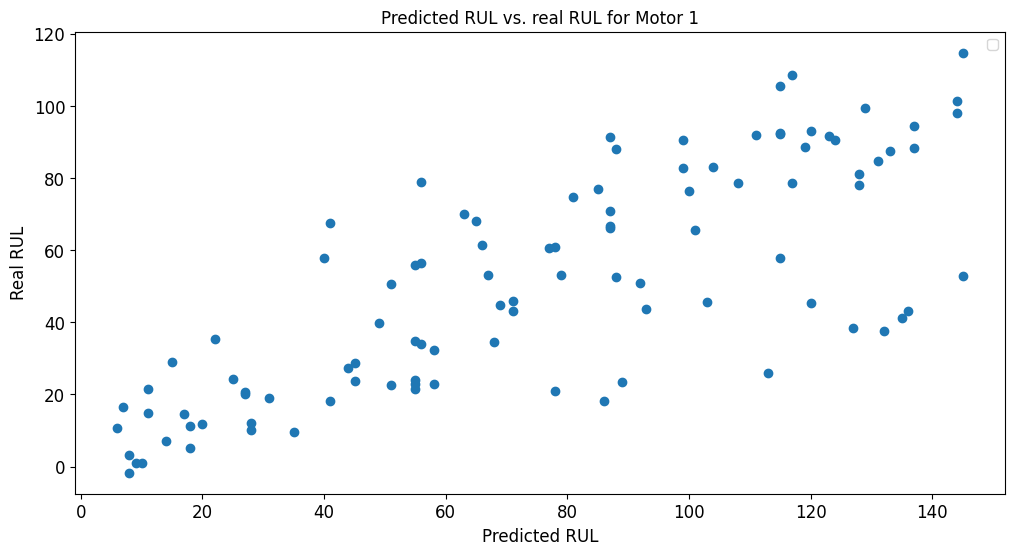

In [74]:
real_rul = pd.read_table("./data/RUL_FD003.txt", header=None, delim_whitespace=True).values

#plot the predicted RUL vs the real RUL for each data point in a scatter plot
plt.figure(figsize=(12,6))

plt.scatter(real_rul, predicted_rul)
plt.legend()
plt.title("Predicted RUL vs. real RUL for Motor 1")
plt.xlabel("Predicted RUL")
plt.ylabel("Real RUL")
plt.show()


## Build a Pipeline including the previous steps
In order to perform a gird search on the hole pipeline and find the best hyperparameters for all steps, we used the Pipeline library from scikit learn. On this pipeline we then could perform a Grid search.

### Define the pipeline for training

#### Step 1: Classes to remove constant columns, normalize the data and do polynomial fitting

In [75]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        X=X.copy()
        X = identify_and_remove_unique_columns(X)
        self.sensor_columns = [col for col in X.columns if 'Sensor Measure' in col]
        self.scaler.fit(X[self.sensor_columns])
        return self

    def transform(self, X):
        X = X.copy()
        X[self.sensor_columns] = self.scaler.transform(X[self.sensor_columns])
        return X 

In [76]:
class PolynomialFitting(BaseEstimator, TransformerMixin):
    def __init__(self, degree=3):
        self.degree = degree

    def fit(self, X, y=None):
        self.sensor_columns = [col for col in X.columns if 'Sensor Measure' in col]
        return self

    def transform(self, X):
        X = X.copy()
        X[self.sensor_columns + ['UnitNumber']], _ = fit_polynomial(X[self.sensor_columns + ['UnitNumber']], degree=self.degree)
        return X

#### Step 2: Class to select relevant features using the Lasso regression

In [77]:
class LassoFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.7):
        self.alpha = alpha
        self.lasso = Lasso(alpha=self.alpha)

    def fit(self, X, y=None):
        x_train=X.copy().drop([ 'UnitNumber', 'rul'], axis=1)
        self.lasso.fit(x_train, X['rul'])
        self.selected_features_ =np.array(X.drop([ 'UnitNumber', 'rul'], axis=1).columns)[(self.lasso.coef_ != 0)]
        return self

    def transform(self, X):
        X=X.copy()
        X = X[[ 'UnitNumber', 'rul'] + list(self.selected_features_)]
        return X

#### Step 3: Class to extract the features using a rolling window with a certain stride

In [78]:
class FeatureExtraction(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=20, stride=20):
        self.window_size = window_size
        self.stride = stride

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        x_train , y_train = extract_features(X, self.window_size, self.stride)
        self.new_labels= y_train
        self.training_data = x_train
        return x_train#pd.concat([x_train,y_train], axis=1)

In [79]:
# Pipeline erstellen
pipeline = Pipeline([
    ('scaler', CustomScaler()),
    ('poly_fit', PolynomialFitting(degree=3)),
    ('lasso_select', LassoFeatureSelection(alpha=2.7)),
    ('feature_extract', FeatureExtraction()),
    ('forest', RandomForestRegressor())
])

### Test the pipeline

#### Load the data

In [80]:
train_data = read_data('./data/train_FD003.txt')
train_data = calculate_rul_and_remove_operational(train_data)

Größe der Daten : Rows 24720, Columns 26


In [81]:
#Testdaten laden
test_data =read_data('./data/test_FD003.txt')
test_data = calculate_rul_and_remove_operational(test_data)
#test_data.head()

Größe der Daten : Rows 16596, Columns 26


### Fit the pipeline on the training dta and test it on the test data

In [90]:
def extract_feature_labels(df, window_length=20, stride=20):
    targets = []
    for unit in df['UnitNumber'].unique():
        unit_df = df[df['UnitNumber'] == unit]
        for start in range(len(unit_df) - window_length,0, -stride):
            end = start + window_length 
            targets.append(unit_df.iloc[end-1]['rul'])
    return pd.DataFrame(targets, columns=['rul'])

In [85]:
y= extract_feature_labels(train_data)
pipeline.fit(train_data, y)

# Accessing each step of the pipeline
scaler_step = pipeline.named_steps['scaler']
poly_fit_step = pipeline.named_steps['poly_fit']
lasso_select_step = pipeline.named_steps['lasso_select']
feature_extract_step = pipeline.named_steps['feature_extract']
forest_step = pipeline.named_steps['forest']

# Inspecting intermediate results
scaled_data = scaler_step.transform(train_data)
poly_fitted_data = poly_fit_step.transform(scaled_data)
selected_features = lasso_select_step.transform(poly_fitted_data)
extracted_features = feature_extract_step.transform(selected_features)
predicted_rul = forest_step.predict(extracted_features)

In [86]:
scaled_data.head()

,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,518.67,-0.187102,-0.712038,-0.780848,14.62,0.781589,-0.341494,-0.704785,-0.097138,-0.353479,-0.385602,-0.227593,-0.389857,0.067687,0.469741,0.03,-0.889364,2388,100.0,0.488019,-0.263512,130
1,1,518.67,0.080574,-0.497656,-0.775732,14.62,0.781589,-0.172755,-0.452071,-0.116658,-0.353479,-0.618882,-0.193802,-0.263369,0.523946,0.729201,0.03,-0.321641,2388,100.0,0.005819,0.375767,130
2,1,518.67,-0.531256,-0.841254,0.116524,14.62,0.781589,-0.207667,-0.262536,0.306267,-0.353479,-0.652208,-0.313608,-0.453101,0.361559,-0.100409,0.03,-0.889364,2388,100.0,-0.556747,-0.175058,130
3,1,518.67,0.883602,-0.362566,-1.248464,14.62,0.781589,0.019257,-0.452071,0.022983,-0.353479,-0.585556,-0.172298,0.052852,0.142821,-0.138419,0.03,-0.321641,2388,100.0,-0.114730,-0.656192,130
4,1,518.67,-1.487242,0.080881,-0.697966,14.62,0.781589,-0.117479,-0.199357,0.602065,-0.353479,-0.885488,-0.144650,-0.263369,0.217955,-0.153292,0.03,-0.321641,2388,100.0,0.608569,0.437416,130


In [87]:
poly_fitted_data.head()

,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,518.67,-0.479029,-0.370564,-0.671737,14.62,0.691252,-0.194179,-0.512835,0.251473,-0.353479,-0.574339,-0.221364,-0.434692,0.339823,0.035303,0.03,-0.795006,2388.0,100.0,0.087283,0.218689,130
1,1,518.67,-0.473452,-0.372604,-0.667666,14.62,0.692488,-0.194883,-0.510064,0.251479,-0.353479,-0.573546,-0.221909,-0.433021,0.340223,0.041340,0.03,-0.783435,2388.0,100.0,0.085108,0.213921,130
2,1,518.67,-0.468021,-0.374598,-0.663665,14.62,0.693713,-0.195583,-0.507329,0.251490,-0.353479,-0.572785,-0.222446,-0.431385,0.340619,0.047265,0.03,-0.772046,2388.0,100.0,0.082978,0.209225,130
3,1,518.67,-0.462735,-0.376545,-0.659731,14.62,0.694926,-0.196280,-0.504629,0.251504,-0.353479,-0.572055,-0.222975,-0.429782,0.341009,0.053081,0.03,-0.760838,2388.0,100.0,0.080894,0.204599,130
4,1,518.67,-0.457590,-0.378445,-0.655864,14.62,0.696129,-0.196975,-0.501963,0.251523,-0.353479,-0.571355,-0.223497,-0.428213,0.341394,0.058787,0.03,-0.749807,2388.0,100.0,0.078854,0.200043,130


In [88]:
selected_features.head()

,UnitNumber,rul,Sensor Measure6,Sensor Measure9,Sensor Measure11
0,1,130,0.691252,0.251473,-0.574339
1,1,130,0.692488,0.251479,-0.573546
2,1,130,0.693713,0.251490,-0.572785
3,1,130,0.694926,0.251504,-0.572055
4,1,130,0.696129,0.251523,-0.571355


In [89]:
extracted_features.head()

,Sensor Measure6_mean,Sensor Measure6_trend,Sensor Measure9_mean,Sensor Measure9_trend,Sensor Measure11_mean,Sensor Measure11_trend,UnitNumber
0,0.781855,0.000024,0.579696,0.003455,2.150132,0.035440,1
1,0.781610,0.000003,0.515230,0.002996,1.501801,0.029468,1
2,0.781577,0.000003,0.459641,0.002568,0.967332,0.024053,1
3,0.781340,0.000024,0.412292,0.002172,0.535572,0.019197,1
4,0.780481,0.000065,0.372545,0.001807,0.195365,0.014898,1


In [91]:
def extract_unit_numbers (df, window_length=20, stride=20):
    targets = []
    units =[]
    for unit in df['UnitNumber'].unique():
        unit_df = df[df['UnitNumber'] == unit]
        for start in range(len(unit_df) - window_length,0, -stride):
            end = start + window_length 
            targets.append(unit_df.iloc[end-1]['rul'])
            units.append(unit)
    df_new = pd.DataFrame(targets, columns =['rul'])
    df_new['UnitNumber'] = units
    return df_new.reset_index(drop=True)

In [92]:
# Predicting on training data
train_error = sqrt(mean_squared_error(predicted_rul, extract_feature_labels(train_data)))
train_error

3.55118428932966

In [93]:
# Predicting on training data
y_test_pred = pipeline.predict(test_data)
y_test_pred = pd.concat([pd.DataFrame(y_test_pred), extract_unit_numbers(test_data)], axis=1)
y_test_pred

,0,rul,UnitNumber
0,63.2,0.0,1
1,81.8,20.0,1
2,95.9,40.0,1
3,110.2,60.0,1
4,118.9,80.0,1
...,...,...,...
771,127.1,130.0,100
772,121.4,130.0,100
773,122.0,130.0,100
774,122.2,130.0,100


In [94]:
y = y_test_pred.groupby('UnitNumber').min(['rul']).drop(['rul'], axis=1)

In [95]:
test_error = sqrt(mean_squared_error(y,RUL_FD003))
test_error

21.136513430554245

### Run grid search on the pipeline

In [96]:
param_grid = {
    'poly_fit__degree': np.arange(1, 11),
    'lasso_select__alpha': np.arange(0.1, 3.1, 0.2),
    'feature_extract__window_size': [15,20,15],
    'feature_extract__stride': [1,5,10,20],
    'forest__n_estimators':  np.arange(10, 101,10),
    'forest__max_depth': np.arange(0.3, 1.1, 0.1)
}

In [44]:
from sklearn.base import clone
from sklearn.model_selection import GroupKFold, cross_val_score

def custom_grid_search(df, pipeline, param_grid):
    # Convert parameter grid dictionary to a list of all possible combinations
    from itertools import product
    grid = list(product(*param_grid.values()))
    
    # Prepare to track the best score and corresponding best parameters
    best_score = float('inf')
    best_params = None
    best_model = None
    
    # Iterate over all combinations of parameters
    for params in grid:
        # Set parameters to the pipeline
        current_params = dict(zip(param_grid.keys(), params))
        print(current_params)
        model = clone(pipeline)
        model.set_params(**current_params)
        

        groups = df['UnitNumber'].values
        X = df
        y = df['rul'].values  # This is the target variable

        gkf = GroupKFold(n_splits=5)

        rmse_sum = 0

        for train_idx, test_idx in gkf.split(X, y,  groups=groups):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            #y_train, y_test = y[train_idx], y[test_idx]
            y_train = extract_feature_labels(X_train)
            y_test =  extract_feature_labels(X_test)

        
            pipeline.fit(X_train.reset_index(drop=True), y_train)
            predictions = pipeline.predict(X_test.reset_index(drop=True))
            rmse = sqrt(mean_squared_error(y_test, predictions))
            rmse_sum += rmse
            
        print(f"Average Fold RMSE: {rmse_sum/5}")
        
            # Update best score and parameters if current model is better
        if rmse_sum/5 < best_score:
            best_score = rmse_sum/5
            best_params = current_params
    print('Best score:', best_score)
    print('Best parameters:', best_params)
    return best_model, best_score, best_params

In [45]:
custom_grid_search(train_data, pipeline, param_grid)

{'poly_fit__degree': 1, 'lasso_select__alpha': 0.1, 'feature_extract__window_size': 15, 'feature_extract__stride': 1, 'forest__n_estimators': 10, 'forest__max_depth': 0.3}


KeyboardInterrupt: 

### First try to do grid search...

In [129]:
param_grid = {
    #'poly_fit__degree': [9],#np.arange(1, 11),
    #'lasso_select__alpha': [0.1],#np.arange(0.1, 3.1, 0.2),
    #'feature_extract__window_size': [20],
    #'feature_extract__stride': [20],
    'forest__n_estimators': [30,50],
    #'forest__max_depth': [0.6] #np.arange(0.3, 1.1, 0.1)
}

kf = KFold(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)


grid_search.fit(train_data, labels)#, pipeline.named_steps['feature_extract'].new_labels.values.ravel())
#best_rf_model = grid_search.best_estimator_

ValueError: Found input variables with inconsistent numbers of samples: [20631, 972]